In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

In [ ]:
dataset_path = os.path.join(os.getcwd(),'Dataset')
datasets=[]
for filename in os.listdir(dataset_path):
    datasets.append(os.path.join(dataset_path,filename))
print(datasets)

In [ ]:
sample = pd.read_csv(datasets[3])
spray = pd.read_csv(datasets[4])
test = pd.read_csv(datasets[5])
train = pd.read_csv(datasets[6])
weather = pd.read_csv(datasets[7])

## EDA

In [ ]:
# train.columns
# train.info()
# train.describe
print(train.isna().sum(),test.isna().sum())


In [ ]:
#visualize EDA
sns.scatterplot(data=train,x='Latitude',y='Longitude',size='NumMosquitos',sizes=(1,100))
#mosquitoes present in a diverse range of locations

In [ ]:
sns.scatterplot(data=train,x='Latitude',y='Longitude',hue='WnvPresent',size='NumMosquitos')
#WNV concentrated in certain locations

In [ ]:
sns.scatterplot(data=train,x='Latitude',y='Longitude',hue='Species')
#CULEX PIPIENS/RESTUANS are the dominant species

## Data Wrangling

In [ ]:
#month column
dates = pd.to_datetime(train['Date'])
train['month'] = dates.apply(lambda x: x.month)

In [ ]:
#explore by species
num_wnv = train.loc[train['WnvPresent']==1]['NumMosquitos'].sum()
num_tot = train['NumMosquitos'].sum()
print(f'Percentage of WNV for all mosquitos: {num_wnv/num_tot*100}%')

In [ ]:
#explore species by percentage with WNV
train.groupby(['Species','WnvPresent'])['NumMosquitos'].sum()/train.groupby(['Species'])['NumMosquitos'].sum()
train.groupby(['Species','WnvPresent'])['NumMosquitos'].sum()/num_tot
#erraticus, salinarius, tarsalis, and territans have low number of data points
#culex pipiens has the highest relative percentage of WNV (15%)

In [ ]:
#convert latitude, longitude, and address data so it is simply a 
# code

# train['Address'].apply(lambda st: st[st.find("IL")+1:st.find(", USA")]).unique()
train['zipcode'] = train['Address'].str.extract(r'(\d{5}\-?\d{0,4})')
#find missing zipcodes
fixed_train = pd.read_csv('train_miss_zipcodes.csv')
fixed_train = fixed_train.set_index('Unnamed: 0')
zipcodes = fixed_train.zipcode.values
train.loc[fixed_train.index,'zipcode']=zipcodes

In [ ]:
# import geopy
# def get_zipcode(df, geolocator, lat_field, lon_field):
#     location = geolocator.reverse((df[lat_field], df[lon_field]))
#     return location.raw['address']['postcode']


# geolocator = geopy.Nominatim(user_agent='geoapiExercises')

# df=train.loc[train['zipcode'].isna()]
# zipcodes = df.apply(get_zipcode, axis=1, geolocator=geolocator, lat_field='Latitude', lon_field='Longitude')

# fixed_train = train.loc[train['zipcode'].isna()]
# fixed_train['zipcode']=zipcodes
# fixed_train.to_csv('train_miss_zipcodes.csv')

In [ ]:
#convert latitude, longitude, and address data so it is simply a zipcode for spray data


# Import packages
from uszipcode import SearchEngine
search = SearchEngine()
import numpy as np

#define zipcode search function
def get_zipcode(lat, lon):
    result = search.by_coordinates(lat = lat, lng = lon, returns = 1)
    return result[0].zipcode

#load columns from dataframe
lat = spray['Latitude']
lon = spray['Longitude']
date = spray.Date

#define latitude/longitude for function
spray_df = pd.DataFrame({'Date':date,'Latitude':lat, 'Longitude':lon})

#add new column with generated zip-code
spray_df['zipcode'] = spray_df.apply(lambda x: get_zipcode(x.Latitude,x.Longitude), axis=1)

#print result
print(spray_df)

#(optional) save as csv
# df.to_csv(r'zip_codes.csv')

In [ ]:
for i in train.Trap.unique():
    if len(train.loc[train.Trap == i].Latitude.unique())>1:
        print(f'lat {i}')
    if len(train.loc[train.Trap == i].Longitude.unique())>1:
        print(f'long {i}')
#only two traps have multiple Latitude/Longitudes
#therefore trap number and latitude/longitude are dependent variables
#we will drop the latitude,longitude, and trap identifier and create dummy columns of the zipcode

In [ ]:
train2 = train.drop(['Trap','Latitude','Longitude','Address','Block','Street','AddressNumberAndStreet','AddressAccuracy'],axis=1)

## Spray Data

In [ ]:
sns.scatterplot(data=spray,x='Latitude',y='Longitude')
#spray data is concentrated in specific locations

In [ ]:
# Create two new columns that sum up the number of sprays at a specific zipcode
# sprays in the past 2 weeks
# sprays in the past 1 month
train2['spray-2w']=0
train2['spray-1m']=0


date = pd.to_datetime(train2.Date)
df2=spray_df[['Date','zipcode']].groupby(['Date','zipcode']).size()
date_spray = pd.to_datetime(df2.index.get_level_values(level=0)\
                                .to_list())

new_index = df2.index.map(lambda x: (pd.to_datetime(x[0]),x[1]))
df2.index = pd.MultiIndex.from_tuples(new_index, names=["date", "zipcode"])

for index,val in df2.items():
    w4_ub = (date - index[0]).apply(lambda x: x.days) < 28
    w2_ub = (date - index[0]).apply(lambda x: x.days) < 14
    w2_lb = (date - index[0]).apply(lambda x: x.days) > 0
    
    zipc = train2.zipcode == index[1]

    train2.loc[w2_ub & w2_lb & zipc,'spray-2w']+=val
    train2.loc[w4_ub & w2_lb & zipc,'spray-1m']+=val

## Weather

In [ ]:
# convert date column to datetime
weather.Date = pd.to_datetime(weather.Date)

# seperate codesum column as categorical columns
res=set()
weather1 = weather.loc[weather['Station']==1]
weather1.CodeSum.str.split().apply(res.update)
for i in res:
    weather1[i] = weather1.CodeSum.apply(lambda x: 1 if i in x else 0)

weather1 = weather1.drop(['CodeSum','Station'],axis=1)

In [ ]:
weather1.PrecipTotal = weather1.PrecipTotal.apply(lambda x: 0.01 if 'T' in x else x)

In [ ]:
# normalize time of sunrise and time of sunset columns
weather1['Sunrise'] = weather1['Sunrise'].replace('-',np.nan)\
                                        .ffill()\
                                        .apply(int)/2400

weather1['Sunset'] = weather1['Sunset'].replace('-',np.nan)\
                                        .ffill()\
                                        .apply(int)/2400

# # forward fill departure data
# weather1.loc[weather1['Depart'].str.contains('M'),'Depart']=np.nan
# weather1['Depart'] = weather1['Depart'].ffill()

# drop columns
# Depth is missing 50%
# Water1 is completely missing
# SnowFall is missing 50%
# SeaLevel does not vary enough to be significant
weather1 = weather1.drop(['Depth','Water1','SnowFall','SeaLevel'],axis=1)      
tavgmiss = weather1.loc[weather1['Heat'].str.contains('M')]
tavgmiss['Tavg'] = (tavgmiss['Tmax']+tavgmiss['Tmin'])/2

weather1.loc[tavgmiss.index]['Tavg']=tavgmiss['Tavg']

#delete any missing values 
for i in weather1.columns:
    try:
        weather1 = weather1.loc[~weather1[i].str.contains('M|T')]
    except:
        pass

In [ ]:
# weather_st1 = weather2.loc[weather2['Station']==1]\
#                         .drop(['Station'],axis=1)

In [ ]:
# lags = ['lag_7d_Date','lag_2w_Date','lag_1mo_Date']
# days = [7,14,28]
# train2.Date = pd.to_datetime(train2.Date)
# train_new = train2.merge(weather1, on='Date')


# for idx,val in enumerate(days):
    
#     lag_dates = list(pd.to_datetime(train2.Date.unique()) - pd.Timedelta(val,unit='d'))
#     train_dates = pd.to_datetime(train2['Date'].unique())
#     lag_dict = dict(zip(train_dates,lag_dates))
#     train_new[lags[idx]+"_Date"] = train2['Date'].apply(lambda x: lag_dict[x])

#     df_lag = weather1.loc[weather1.Date.isin(train_dates)]
#     df_lag = df_lag.add_prefix(lags[idx]+'_')

#     train_new = pd.merge(train_new, df_lag, left_on='Date', right_on=lags[idx]+'_Date')
    
# train_new = train_new.loc[:,[i for i in train_new.columns if 'Date' not in i or 'CodeSum' not in i]]


In [ ]:
lags = ['lag_7d','lag_2w','lag_1mo']
days = [7,14,28]
train2.Date = pd.to_datetime(train2.Date)
train_new = train2.merge(weather1, on='Date')
train_new = train_new.drop(['Tmin','Tmax','Sunset','DewPoint','Sunrise'],axis=1)

for idx,val in enumerate(days):
    train_new[lags[idx]+'_Date'] = train_new['Date'].apply(lambda x: x-pd.Timedelta(val,unit='d'))
    
    lag_dates = train_new[lags[idx]+'_Date'].unique()
    df_lag = weather1.loc[weather1.Date.isin(lag_dates)]\
                        .drop(['Sunrise','Sunset','DewPoint','Tmax','Tmin'],axis=1)

    df_lag = df_lag.add_prefix(lags[idx]+'_')



    train_new = train_new.merge(df_lag, left_on=lags[idx]+'_Date', right_on=lags[idx]+'_Date')

words= ['Date','CodeSum']
for w in words:
    train_new = train_new.drop([i for i in train_new.columns if w in i],axis=1)
train_new


## Cluster

In [ ]:
train_new = pd.get_dummies(train_new,columns=['Species','zipcode','month','Tavg'])
train_new = train_new.loc[:,~train_new.columns.duplicated()].copy()


In [ ]:
corrmat = train_new.corr()
sns.heatmap(corrmat)

In [ ]:
wnv = abs(corrmat['WnvPresent']).sort_values(ascending=False)
mosq = abs(corrmat['NumMosquitos']).sort_values(ascending=False)

In [217]:
# select the highest correlated columns with WNVPresent
df_wnv = train_new[wnv[wnv>0.01].index]

In [221]:
# check for collinearity using:
# VIF = 1 / tolerance
# tolerance = 1 - Rj2
# least square regression 
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

df_wnv2 = df_wnv.drop(['lag_7d_TSRA','lag_2w_TSRA','lag_1mo_TSRA','TSRA','lag_1mo_ResultSpeed','lag_1mo_FU',
                        'lag_2w_ResultSpeed','lag_7d_ResultSpeed','lag_7d_ResultDir','lag_2w_ResultDir','lag_1mo_ResultDir',
                        'lag_7d_FG+','lag_7d_MIFG','Species_CULEX PIPIENS/RESTUANS','Tavg_81','lag_2w_VCTS','lag_1mo_RA'],axis=1)

df_vif=calc_vif(df_wnv2.astype(float))
df_vif.sort_values('VIF',ascending=False)

,variables,VIF
12,ResultSpeed,9.045273
86,lag_7d_BR,6.062613
2,month_8,5.973940
9,lag_7d_TS,5.933982
31,lag_1mo_BR,5.665306
...,...,...
85,zipcode_60613,1.016354
58,zipcode_60646,1.014191
82,zipcode_60605,1.013703
89,zipcode_60615,1.012335


In [222]:
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.under_sampling import RandomUnderSampler

X = df_wnv2.drop(['WnvPresent'],axis=1)
y = df_wnv2['WnvPresent']

rus = RandomUnderSampler(sampling_strategy=1)


X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.25,random_state=42)


X_res, y_res = rus.fit_resample(X_train,y_train)


# SMOTE alternative
# sm = SMOTE(random_state=42)
# X_res, y_res = sm.fit_resample(X_train, y_train)

<AxesSubplot:ylabel='WnvPresent'>

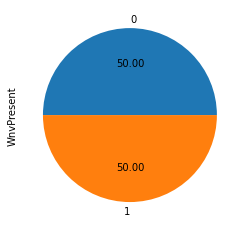

In [223]:
# visualize the sampler
y_res.value_counts().plot.pie(autopct='%.2f')

## KNN Classifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import confusion_matrix

k_range = list(range(1,31))
weight_options = ['uniform','distance']

param_grid = dict(n_neighbors=k_range, weights=weight_options)

knn = KNeighborsClassifier()
grid = GridSearchCV(knn, param_grid, cv=10, scoring='f1')
grid.fit(X_res, y_res)


knn=KNeighborsClassifier(**grid.best_params_)
knn.fit(X_res,y_res)
y_pred = knn.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

print('From Confusion Matrix:')
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

report = classification_report(y_test,y_pred,target_names=['No WNV','WNV Present'],output_dict=True)
pd.DataFrame(report)

## Random Forest

In [ ]:
from scipy.stats import randint
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV



# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 80, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [2,4]
# Minimum number of samples required to split a node
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
bootstrap = [True, False]

param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestClassifier()

rf_RandomGrid = RandomizedSearchCV(estimator = rf, param_distributions = param_grid, cv = 10, verbose=2, n_jobs = 4)
rf_RandomGrid.fit(X_train, y_train)
best_params = rf_RandomGrid.best_params_


rf = RandomForestClassifier()
rf.set_params(**best_params)
rf.fit(X_res,y_res)
y_pred = rf.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

print('From Confusion Matrix:')
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

pd.DataFrame(classification_report(y_test, y_pred,output_dict=True))


# feat_importances = pd.Series(rf.feature_importances_, index=X_res.columns)
# feat_importances.nlargest(20).plot(kind='barh')

In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver='lbfgs',max_iter=3000)
lr.fit(X_res,y_res)
y_pred = lr.predict(X_test)
report = classification_report(y_test,y_pred,target_names=['No WNV','WNV Present'],output_dict=True)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

print('From Confusion Matrix:')
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)
pd.DataFrame(report)



In [224]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier()

params = {
    "n_estimators":[5,50,250,500],
    "max_depth":[1,3,5,7,9],
    "learning_rate":[0.01,0.1,0.5,1,10,100]
}

cv = RandomizedSearchCV(clf, params)
cv.fit(X_res,y_res)

best_params = cv.best_params_
clf.set_params(**best_params)
clf.fit(X_res, y_res)

y_pred = clf.predict(X_test)
report = classification_report(y_test,y_pred,target_names=['No WNV','WNV Present'],output_dict=True)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

print('From Confusion Matrix:')
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)
pd.DataFrame(report)

From Confusion Matrix:
True Negatives: 1831
False Positives: 582
False Negatives: 30
True Positives: 99


,No WNV,WNV Present,accuracy,macro avg,weighted avg
precision,0.983880,0.145374,0.759245,0.564627,0.941328
recall,0.758806,0.767442,0.759245,0.763124,0.759245
f1-score,0.856809,0.244444,0.759245,0.550627,0.825733
support,2413.000000,129.000000,0.759245,2542.000000,2542.000000


In [ ]:
feat_importances = pd.Series(clf.feature_importances_, index=X_res.columns)
feat_importances.nlargest(20).plot(kind='barh')


In [ ]:
import shap
shap.initjs()
explainer = shap.Explainer(clf.predict, X_test)
shap_values = explainer(X_test)
shap.summary_plot(shap_values.values, X_test, plot_type='bar')

In [225]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier


abc = AdaBoostClassifier(base_estimator=DecisionTreeClassifier())

parameters = {'base_estimator__max_depth':[i for i in range(1,10,1)],
              'base_estimator__min_samples_leaf':[5,10],
              'n_estimators':[10,50,250,1000],
              'learning_rate':[0.01,0.1,1,10]}

abc_clf = RandomizedSearchCV(abc, parameters,verbose=3,scoring='f1',n_jobs=-1)
abc_clf.fit(X_res,y_res)

abc.set_params(**abc_clf.best_params_)
abc.fit(X_res, y_res)
y_pred = abc.predict(X_test)
report = classification_report(y_test,y_pred,target_names=['No WNV','WNV Present'],output_dict=True)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

print('From Confusion Matrix:')
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)
pd.DataFrame(report)



Fitting 5 folds for each of 10 candidates, totalling 50 fits
From Confusion Matrix:
True Negatives: 1817
False Positives: 596
False Negatives: 30
True Positives: 99


,No WNV,WNV Present,accuracy,macro avg,weighted avg
precision,0.983757,0.142446,0.753737,0.563102,0.941063
recall,0.753005,0.767442,0.753737,0.760223,0.753737
f1-score,0.853052,0.240291,0.753737,0.546671,0.821956
support,2413.000000,129.000000,0.753737,2542.000000,2542.000000


In [226]:
y_score = clf.predict_proba(X_test)[:,1]
y_score

array([0.77734483, 0.33853767, 0.87438534, ..., 0.80559041, 0.5335823 ,
       0.32581827])

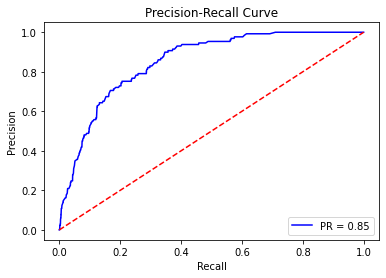

In [227]:
from sklearn.metrics import roc_curve, roc_auc_score


fpr, tpr, thresholds = roc_curve(y_test, y_score)
auc_score = roc_auc_score(y_test, y_score)

import matplotlib.pyplot as plt
plt.title('Precision-Recall Curve')
plt.plot(fpr, tpr, 'b', label = 'PR = %0.2f' % auc_score)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')

plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [ ]:
# observe the best performance from the gradient boosting algorithm
# based on the f1-score: 0.2444
# we therefore perform a shaply analysis to understand the model features which have the largest influence in predicting WNV

Permutation explainer: 2543it [01:09, 31.45it/s]                          


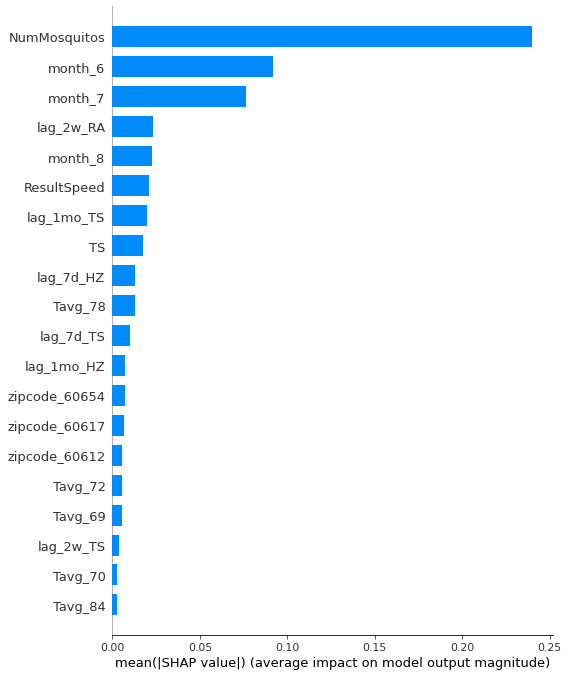

In [228]:
explainer = shap.Explainer(clf.predict, X_test)
shap_values = explainer(X_test)
shap.summary_plot(shap_values.values, X_test, plot_type='bar')

In [ ]:
# highest impact features:
# NumMosquitos, month_6, month_7

# the most effective way to decrease the presence of the WNV is to limit the mosquito population
# the occurence of sprays does not currently have an appreciable effect

# It is recommended that the city of Chicago increase the location of sprays 